#**Discovering Symbolic Models from Deep Learning with Inductive Biases**
## Implementazione del [modello originale proposto dagli autori](https://github.com/MilesCranmer/symbolic_deep_learning).

Contestabile Giorgio, De Mei Vincenzo, Macaluso Nicolò

[Link alla cartella GitHuB contenente codici e risultati del presente lavoro](https://github.com/gitNoYokai/symbolic_deep_learning_GNV)

Il progetto qui proposto vuole mostrare come sia possibile convertire una rete neurale in una semplice equazione analitica.
Gli autori hanno ritenuto opportuno suddividere la discussione in due notebook: 

1.   il presente, **GNN_Training**, dove vengono simulati sistemi di particelle interagenti tramite uno specifico potenziale (scelto dall'utente) ed ogni evento viene memorizzato sotto forma di un grafo dove le particelle vanno a costituire i nodi. Dagli edge vengono estrapolate le informazioni sull'interazione, dunque segue un allenamento della rete sui valori dell'accelerazione;   
2.   il notebook **Symbolic_Regression**, contenente la regressione simbolica dei risultati ottenuti dalla simulazione.




# 1. Preambolo e Simulazione

### Importazione delle librerie di base

In [ ]:
# Basic pre-reqs:
import numpy as np
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
!pip install celluloid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
version_nums = torch.__version__.split('.')
# Torch Geometric seems to always build for *.*.0 of torch :
version_nums[-1] = '0' + version_nums[-1][1:]
os.environ['TORCH'] = '.'.join(version_nums)
 
!pip install --upgrade torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}.html && pip install --upgrade torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}.html && pip install --upgrade torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 8.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 3.5 MB 11.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 7.0 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=da0fd39855a4da30a4e2028adad9682ca14da25dd884f80be22b43d3543ef609
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [ ]:
!wget https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/models.py -O models.py
!wget https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/simulate.py -O simulate.py

--2022-11-03 17:15:20--  https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9647 (9.4K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   9.42K  --.-KB/s    in 0s      

2022-11-03 17:15:20 (67.6 MB/s) - ‘models.py’ saved [9647/9647]

--2022-11-03 17:15:20--  https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/simulate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9752 (9.5K) [text/p

### Importazione delle librerie per la modellizzazione della rete (**models**) e per le simulazioni fisiche (**simulate**)

In [ ]:
import models
import simulate

In [ ]:
torch.ones(1).cuda()

tensor([1.], device='cuda:0')

### Scelta della simulazione

In [ ]:
# Number of simulations to run (it's fast, don't worry):
ns = 10000
# Potential (see below for options)
sim = 'spring'
# Number of nodes
n = 5
# Dimension
dim = 2
# Number of time steps
nt = 1000


#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
 {'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
 {'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
]


#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
print('Running on', title)

Running on spring_n=5_dim=2_nt=1000_dt=0.01


### Generazione dei dati della simulazione

In [ ]:
from simulate import SimulationDataset
s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
# Update this to your own dataset, or regenerate:
base_str = './'
data_str = title
s.simulate(ns)

In [ ]:
data = s.data
s.data.shape

(10000, 500, 5, 6)

### Visualizzazione della simulazione

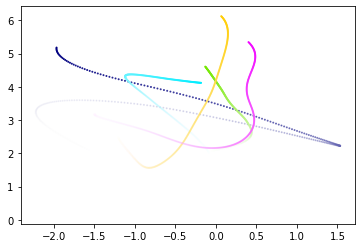

In [ ]:
s.plot(0, animate=True, plot_size=False)

### Preparazione dei dati

In [ ]:
accel_data = s.get_acceleration()

In [ ]:
X = torch.from_numpy(np.concatenate([s.data[:, i] for i in range(0, s.data.shape[1], 5)]))
y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, s.data.shape[1], 5)]))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# 2. Impostazione della Rete e Training

In [ ]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing

In [ ]:
from models import OGN, varOGN, make_packer, make_unpacker, get_edge_index

### Scelta della Loss Function

Per applicare **Bottleneck**, e' necessario porre la dimensionalita' del messaggi pari a quella del sistema

In [ ]:
aggr = 'add'
hidden = 300

test = '_l1_'

#This test applies an explicit bottleneck:

msg_dim = 100
n_f = data.shape[3]

### Note degli Autori sulle Loss Function

L1 loss: we simply add the loss to the batch number. I.e., * 32 for batch size 32.

KL loss: model the messages as a distribution with the prior a Gaussian. The means add in the final Gaussian. 
Recall in the D_KL(p||q), the prior is q.  Then, for sigma_q = 1, mu_q = 0, we have ($p=1$):

$$D_{KL}(p||q) = \frac{\sigma_p^2 + \mu_p^2}{2} -\log({\sigma_p}) - \frac{1}{2}$$

### Data Loader personalizzato scelto dagli Autori

In [ ]:
from torch_geometric.data import Data, DataLoader

In [ ]:
from models import get_edge_index

In [ ]:
edge_index = get_edge_index(n, sim)

### Inizializzazione del modello

In [ ]:
if test == '_kl_':
    ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
else:
    ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()

messages_over_time = []
ogn = ogn.cuda()

In [ ]:
_q = Data(
    x=X_train[0].cuda(),
    edge_index=edge_index.cuda(),
    y=y_train[0].cuda())
ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 

(tensor([[0.0069, 0.0144],
         [0.0142, 0.0268],
         [0.0064, 0.0085],
         [0.0127, 0.0004],
         [0.0209, 0.0101]], device='cuda:0', grad_fn=<AddmmBackward0>),
 torch.Size([5, 2]),
 torch.Size([5, 2]),
 tensor(29.7562, device='cuda:0', grad_fn=<SumBackward0>))

### Organizzazione dei dati

In [ ]:
batch = int(64 * (4 / n)**2)
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=1024,
    shuffle=True
)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

### Definizione delle Loss Function

In [ ]:
def new_loss(self, g, augment=True, square=False):
    if square:
        return torch.sum((g.y - self.just_derivative(g, augment=augment))**2)
    else:
        base_loss = torch.sum(torch.abs(g.y - self.just_derivative(g, augment=augment)))
        if test in ['_l1_', '_kl_']:
            s1 = g.x[self.edge_index[0]]
            s2 = g.x[self.edge_index[1]]
            if test == '_l1_':
                m12 = self.message(s1, s2)
                regularization = 1e-2
                #Want one loss value per row of g.y:
                normalized_l05 = torch.sum(torch.abs(m12))
                return base_loss, regularization * batch * normalized_l05 / n**2 * n
            elif test == '_kl_':
                regularization = 1
                #Want one loss value per row of g.y:
                tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
                raw_msg = self.msg_fnc(tmp)
                mu = raw_msg[:, 0::2]
                logvar = raw_msg[:, 1::2]
                full_kl = torch.sum(torch.exp(logvar) + mu**2 - logvar)/2.0
                return base_loss, regularization * batch * full_kl / n**2 * n
        return base_loss

### Impostazione dei parametri per il training

Per vari potenziali, 150-200 epoche sono sufficienti ad ottenere buoni risultati

In [ ]:
init_lr = 1e-3

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

total_epochs = 200

batch_per_epoch = int(1000*10 / (batch/32.0))

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

batch_per_epoch

8000

In [ ]:
epoch = 0

from tqdm import tqdm

### Organizzazione dei messaggi

In [ ]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

# Record messages over test dataset here:
newtestloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

### Funzione per la registrazione dell'output della rete

In [ ]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]]
        s2 = tmp.x[tmp.edge_index[1]]
        tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
        if test == '_kl_':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]


        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info

In [ ]:
recorded_models = []

### Ciclo di Training

In [ ]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.cuda()
    total_loss = 0.0
    i = 0
    num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x.cuda()
            ginput.y = ginput.y.cuda()
            ginput.edge_index = ginput.edge_index.cuda()
            ginput.batch = ginput.batch.cuda()
            if test in ['_l1_', '_kl_']:
                loss, reg = new_loss(ogn, ginput, square=False)
                ((loss + reg)/int(ginput.batch[-1]+1)).backward()
            else:
                loss = ogn.loss(ginput, square=False)
                (loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)

    cur_loss = total_loss/num_items
    print(cur_loss)
    cur_msgs = get_messages(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(ogn.state_dict())

  0%|          | 0/200 [00:00<?, ?it/s]

17.628688132953645


  0%|          | 1/200 [01:05<3:36:17, 65.22s/it]

11.689596088409424


  2%|▏         | 3/200 [03:00<3:14:00, 59.09s/it]

8.406256927633285
6.9227801846504216


  2%|▏         | 4/200 [03:55<3:07:39, 57.45s/it]

6.133290254926681


  2%|▎         | 5/200 [04:52<3:05:42, 57.14s/it]

5.691384653902054


  3%|▎         | 6/200 [05:46<3:01:30, 56.14s/it]

5.335205566859245


  4%|▎         | 7/200 [06:40<2:58:21, 55.45s/it]

5.003190497589111


  4%|▍         | 8/200 [07:34<2:55:45, 54.93s/it]

4.764280237531662


  4%|▍         | 9/200 [08:28<2:53:53, 54.63s/it]

4.489131951498985


  5%|▌         | 10/200 [09:22<2:52:26, 54.46s/it]

4.35522610399723


  6%|▌         | 11/200 [10:16<2:51:08, 54.33s/it]

4.047093890023231


  6%|▌         | 12/200 [11:10<2:49:58, 54.25s/it]

3.814693703854084


  7%|▋         | 14/200 [13:01<2:50:14, 54.92s/it]

3.4241182470321654
3.104218093574047


  8%|▊         | 15/200 [13:55<2:48:31, 54.66s/it]

2.8145676868438723


  8%|▊         | 16/200 [14:49<2:46:54, 54.43s/it]

2.5992313450813294


  8%|▊         | 17/200 [15:43<2:45:35, 54.29s/it]

2.3744443884730337


  9%|▉         | 18/200 [16:37<2:44:21, 54.18s/it]

2.221127521312237


 10%|▉         | 19/200 [17:31<2:44:07, 54.40s/it]

2.117966711688042


 10%|█         | 20/200 [18:27<2:44:00, 54.67s/it]

1.9941603827893735


 10%|█         | 21/200 [19:22<2:43:33, 54.82s/it]

1.943797409915924


 11%|█         | 22/200 [20:16<2:42:07, 54.65s/it]

1.9049190564393996


 12%|█▏        | 23/200 [21:11<2:41:09, 54.63s/it]

1.9194117847979069


 12%|█▏        | 24/200 [22:05<2:39:32, 54.39s/it]

1.9165901453256606


 12%|█▎        | 25/200 [22:59<2:38:12, 54.24s/it]

1.9308849395275116


 13%|█▎        | 26/200 [23:52<2:36:55, 54.11s/it]

1.9317237886607648


 14%|█▎        | 27/200 [24:50<2:38:53, 55.11s/it]

1.9212913757503032


 14%|█▍        | 28/200 [25:44<2:36:53, 54.73s/it]

1.9339495910584927


 14%|█▍        | 29/200 [26:37<2:35:07, 54.43s/it]

1.96742122528553


 15%|█▌        | 30/200 [27:31<2:33:37, 54.22s/it]

1.9993688317835332


 16%|█▌        | 31/200 [28:26<2:33:07, 54.36s/it]

1.9319128227591515


 16%|█▌        | 32/200 [29:20<2:31:48, 54.22s/it]

1.9588682364821435


 16%|█▋        | 33/200 [30:16<2:32:48, 54.90s/it]

1.9769726264417171


 17%|█▋        | 34/200 [31:10<2:31:08, 54.63s/it]

1.9880266654968262


 18%|█▊        | 35/200 [32:04<2:29:23, 54.32s/it]

1.9810479347348213


 18%|█▊        | 36/200 [32:58<2:28:22, 54.28s/it]

1.9192735146403312


 18%|█▊        | 37/200 [33:52<2:27:32, 54.31s/it]

1.9855253448486327


 19%|█▉        | 38/200 [34:46<2:26:02, 54.09s/it]

1.9606062936723232


 20%|█▉        | 39/200 [35:41<2:25:59, 54.41s/it]

1.931182989883423


 20%|██        | 40/200 [36:36<2:25:11, 54.45s/it]

1.9638587536096572


 20%|██        | 41/200 [37:30<2:24:20, 54.47s/it]

1.9168800881683827


 21%|██        | 42/200 [38:23<2:22:34, 54.14s/it]

1.9486762542188167


 22%|██▏       | 43/200 [39:17<2:21:06, 53.93s/it]

1.956109191596508


 22%|██▏       | 44/200 [40:13<2:21:44, 54.51s/it]

1.9447052042961122


 22%|██▎       | 45/200 [41:07<2:20:28, 54.38s/it]

1.9172758108139039


 23%|██▎       | 46/200 [42:00<2:18:57, 54.14s/it]

1.9267974276959896


 24%|██▎       | 47/200 [42:54<2:17:26, 53.90s/it]

1.9175738402485847


 24%|██▍       | 48/200 [43:48<2:17:05, 54.12s/it]

1.9210337285220622


 24%|██▍       | 49/200 [44:43<2:16:13, 54.13s/it]

1.883549352222681


 25%|██▌       | 50/200 [45:38<2:16:16, 54.51s/it]

1.8888115977704525


 26%|██▌       | 51/200 [46:32<2:14:40, 54.23s/it]

1.89246300034523


 26%|██▌       | 52/200 [47:26<2:13:54, 54.29s/it]

1.8922416787207126


 26%|██▋       | 53/200 [48:19<2:12:16, 53.99s/it]

1.8639379940032959


 27%|██▋       | 54/200 [49:13<2:11:23, 54.00s/it]

1.8319295059978962


 28%|██▊       | 55/200 [50:07<2:10:05, 53.83s/it]

1.7723135784089565


 28%|██▊       | 56/200 [51:03<2:10:47, 54.49s/it]

1.8005763457417487


 28%|██▊       | 57/200 [51:56<2:09:16, 54.24s/it]

1.7671888260245323


 29%|██▉       | 58/200 [52:51<2:08:20, 54.23s/it]

1.7351097565710545


 30%|██▉       | 59/200 [53:44<2:06:52, 53.99s/it]

1.7248788451492787


 30%|███       | 60/200 [54:37<2:05:33, 53.81s/it]

1.731840084809065


 30%|███       | 61/200 [55:32<2:05:14, 54.06s/it]

1.6746033183515072


 31%|███       | 62/200 [56:26<2:04:30, 54.14s/it]

1.6784191938400268


 32%|███▏      | 63/200 [57:21<2:03:58, 54.30s/it]

1.6354159945964812


 32%|███▏      | 64/200 [58:14<2:02:28, 54.03s/it]

1.623838190162182


 32%|███▎      | 65/200 [59:09<2:01:36, 54.05s/it]

1.6121013718187809


 33%|███▎      | 66/200 [1:00:03<2:00:48, 54.10s/it]

1.5776519691646098


 34%|███▎      | 67/200 [1:00:56<1:59:28, 53.90s/it]

1.5378496212780475


 34%|███▍      | 68/200 [1:01:51<1:59:27, 54.30s/it]

1.5441097832143307


 34%|███▍      | 69/200 [1:02:46<1:59:02, 54.52s/it]

1.5394780956149101


 35%|███▌      | 70/200 [1:03:42<1:58:42, 54.79s/it]

1.4934845985412597


 36%|███▌      | 71/200 [1:04:36<1:57:41, 54.74s/it]

1.5080997710347175


 36%|███▌      | 72/200 [1:05:31<1:56:41, 54.70s/it]

1.488400678151846


 36%|███▋      | 73/200 [1:06:26<1:55:55, 54.77s/it]

1.4697193816184997


 37%|███▋      | 74/200 [1:07:22<1:56:04, 55.27s/it]

1.450597098737955


 38%|███▊      | 75/200 [1:08:19<1:55:53, 55.63s/it]

1.4429609597742556


 38%|███▊      | 76/200 [1:09:13<1:54:14, 55.28s/it]

1.4296492627382278


 38%|███▊      | 77/200 [1:10:08<1:53:05, 55.16s/it]

1.4081741797029972


 39%|███▉      | 78/200 [1:11:05<1:52:57, 55.55s/it]

1.382356183385849


 40%|███▉      | 79/200 [1:12:00<1:51:37, 55.35s/it]

1.371982481497526


 40%|████      | 80/200 [1:12:56<1:51:28, 55.74s/it]

1.3706199474990368


 40%|████      | 81/200 [1:13:51<1:49:53, 55.41s/it]

1.3433024811387062


 41%|████      | 82/200 [1:14:47<1:49:26, 55.65s/it]

1.35329400010705


 42%|████▏     | 83/200 [1:15:42<1:48:03, 55.42s/it]

1.3037850616633893


 42%|████▏     | 84/200 [1:16:37<1:46:44, 55.21s/it]

1.30662845749259


 42%|████▎     | 85/200 [1:17:31<1:45:03, 54.81s/it]

1.3091373214185238


 43%|████▎     | 86/200 [1:18:28<1:45:35, 55.57s/it]

1.294673160868883


 44%|████▎     | 87/200 [1:19:22<1:43:31, 54.97s/it]

1.2764355787336827


 44%|████▍     | 88/200 [1:20:15<1:41:47, 54.53s/it]

1.2411829783499242


 44%|████▍     | 89/200 [1:21:09<1:40:24, 54.28s/it]

1.250906235688925


 45%|████▌     | 90/200 [1:22:03<1:39:37, 54.34s/it]

1.217532677257061


 46%|████▌     | 91/200 [1:22:57<1:38:15, 54.08s/it]

1.2135808182179928


 46%|████▌     | 92/200 [1:23:50<1:37:01, 53.91s/it]

1.2099586520314216


 46%|████▋     | 93/200 [1:24:46<1:37:18, 54.57s/it]

1.163663967102766


 47%|████▋     | 94/200 [1:25:40<1:36:07, 54.41s/it]

1.1813170823693275


 48%|████▊     | 95/200 [1:26:34<1:34:55, 54.24s/it]

1.1794601285874844


 48%|████▊     | 96/200 [1:27:28<1:33:39, 54.03s/it]

1.1639700109481812


 48%|████▊     | 97/200 [1:28:22<1:32:48, 54.06s/it]

1.1249382745087146


 49%|████▉     | 98/200 [1:29:16<1:32:06, 54.18s/it]

1.105110647970438


 50%|████▉     | 99/200 [1:30:12<1:31:45, 54.51s/it]

1.0774461388349532


 50%|█████     | 100/200 [1:31:05<1:30:20, 54.21s/it]

1.0939350331008435


 50%|█████     | 101/200 [1:32:00<1:29:33, 54.28s/it]

1.0732539862155914


 51%|█████     | 102/200 [1:32:54<1:28:37, 54.26s/it]

1.0550133078932762


 52%|█████▏    | 103/200 [1:33:47<1:27:26, 54.08s/it]

1.0477326590657234


 52%|█████▏    | 104/200 [1:34:41<1:26:16, 53.92s/it]

1.0288371897757054


 52%|█████▎    | 105/200 [1:35:37<1:26:22, 54.55s/it]

1.0268700679063798


 53%|█████▎    | 106/200 [1:36:31<1:25:20, 54.47s/it]

1.0244239958822727


 54%|█████▎    | 107/200 [1:37:25<1:24:01, 54.21s/it]

1.0022145208477975


 54%|█████▍    | 108/200 [1:38:18<1:22:50, 54.03s/it]

0.9824624789476395


 55%|█████▍    | 109/200 [1:39:12<1:21:37, 53.81s/it]

0.9585656549751759


 55%|█████▌    | 110/200 [1:40:05<1:20:34, 53.71s/it]

0.9593633646070957


 56%|█████▌    | 111/200 [1:41:00<1:19:57, 53.90s/it]

0.9578160102128983


 56%|█████▌    | 112/200 [1:41:53<1:18:50, 53.76s/it]

0.9215852191865445


 56%|█████▋    | 113/200 [1:42:49<1:18:59, 54.48s/it]

0.9123521157860756


 57%|█████▋    | 114/200 [1:43:43<1:17:42, 54.21s/it]

0.9007439907729625


 57%|█████▊    | 115/200 [1:44:37<1:16:50, 54.24s/it]

0.9060738414108753


 58%|█████▊    | 116/200 [1:45:30<1:15:34, 53.98s/it]

0.862579100266099


 58%|█████▊    | 117/200 [1:46:25<1:14:50, 54.11s/it]

0.8773628824979067


 59%|█████▉    | 118/200 [1:47:19<1:13:45, 53.97s/it]

0.8548967205762863


 60%|█████▉    | 119/200 [1:48:14<1:13:36, 54.53s/it]

0.8277126592934132


 60%|██████    | 120/200 [1:49:08<1:12:15, 54.19s/it]

0.8384565613806247


 60%|██████    | 121/200 [1:50:02<1:11:20, 54.18s/it]

0.8174208502888679


 61%|██████    | 122/200 [1:50:55<1:10:08, 53.95s/it]

0.8037194779425859


 62%|██████▏   | 123/200 [1:51:50<1:09:23, 54.07s/it]

0.7937861321806907


 62%|██████▏   | 124/200 [1:52:46<1:09:16, 54.69s/it]

0.7887391748040915


 62%|██████▎   | 125/200 [1:53:39<1:07:50, 54.27s/it]

0.77395189653337


 63%|██████▎   | 126/200 [1:54:33<1:06:57, 54.29s/it]

0.761165269228816


 64%|██████▎   | 127/200 [1:55:27<1:05:40, 53.98s/it]

0.749856449201703


 64%|██████▍   | 128/200 [1:56:21<1:04:51, 54.04s/it]

0.7301238804727793


 64%|██████▍   | 129/200 [1:57:15<1:03:47, 53.91s/it]

0.7400659289956093


 65%|██████▌   | 130/200 [1:58:10<1:03:37, 54.53s/it]

0.708488594865799


 66%|██████▌   | 131/200 [1:59:04<1:02:17, 54.16s/it]

0.6965832210749388


 66%|██████▌   | 132/200 [1:59:58<1:01:24, 54.18s/it]

0.6937332650959491


 66%|██████▋   | 133/200 [2:00:51<1:00:14, 53.95s/it]

0.678604259800911


 67%|██████▋   | 134/200 [2:01:45<59:13, 53.84s/it]  

0.6692345787644386


 68%|██████▊   | 135/200 [2:02:39<58:16, 53.78s/it]

0.6685266905784607


 68%|██████▊   | 136/200 [2:03:33<57:42, 54.10s/it]

0.6446857219696045


 68%|██████▊   | 137/200 [2:04:29<57:07, 54.40s/it]

0.6368963075339794


 69%|██████▉   | 138/200 [2:05:22<55:55, 54.13s/it]

0.6257938939452171


 70%|██████▉   | 139/200 [2:06:15<54:46, 53.87s/it]

0.612224599775672


 70%|███████   | 140/200 [2:07:10<53:59, 53.99s/it]

0.602318785700202


 70%|███████   | 141/200 [2:08:04<53:11, 54.09s/it]

0.5973590043276549


 71%|███████   | 142/200 [2:08:59<52:36, 54.41s/it]

0.5845795820593834


 72%|███████▏  | 143/200 [2:09:52<51:23, 54.10s/it]

0.5736772944092751


 72%|███████▏  | 144/200 [2:10:47<50:42, 54.32s/it]

0.5619672937572002


 72%|███████▎  | 145/200 [2:11:41<49:35, 54.11s/it]

0.55410063611269


 73%|███████▎  | 146/200 [2:12:34<48:28, 53.87s/it]

0.5412272897869349


 74%|███████▎  | 147/200 [2:13:28<47:31, 53.79s/it]

0.5363147085398435


 74%|███████▍  | 148/200 [2:14:25<47:24, 54.70s/it]

0.5245980723649264


 74%|███████▍  | 149/200 [2:15:18<46:09, 54.30s/it]

0.5154570666581392


 75%|███████▌  | 150/200 [2:16:12<45:02, 54.06s/it]

0.5049549414008856


 76%|███████▌  | 151/200 [2:17:05<44:00, 53.89s/it]

0.5004345154762269


 76%|███████▌  | 152/200 [2:17:59<43:12, 54.02s/it]

0.489792436376214


 76%|███████▋  | 153/200 [2:18:54<42:23, 54.13s/it]

0.4816024601906538


 77%|███████▋  | 154/200 [2:19:49<41:43, 54.43s/it]

0.477634825450182


 78%|███████▊  | 155/200 [2:20:42<40:34, 54.10s/it]

0.4667747450619936


 78%|███████▊  | 156/200 [2:21:37<39:53, 54.41s/it]

0.45712121730446814


 78%|███████▊  | 157/200 [2:22:31<38:46, 54.10s/it]

0.4567538865536451


 79%|███████▉  | 158/200 [2:23:24<37:45, 53.95s/it]

0.44451660917401314


 80%|███████▉  | 159/200 [2:24:20<37:17, 54.57s/it]

0.43772695102095605


 80%|████████  | 160/200 [2:25:15<36:19, 54.48s/it]

0.42803630913496016


 80%|████████  | 161/200 [2:26:08<35:12, 54.18s/it]

0.4284813571125269


 81%|████████  | 162/200 [2:27:01<34:08, 53.92s/it]

0.4186813461303711


 82%|████████▏ | 163/200 [2:27:55<33:16, 53.96s/it]

0.4131349481731653


 82%|████████▏ | 164/200 [2:28:50<32:25, 54.03s/it]

0.409112862983346


 82%|████████▎ | 165/200 [2:29:45<31:43, 54.39s/it]

0.4020460205048323


 83%|████████▎ | 166/200 [2:30:38<30:38, 54.07s/it]

0.3952194563359022


 84%|████████▎ | 167/200 [2:31:32<29:46, 54.13s/it]

0.39057363107204435


 84%|████████▍ | 168/200 [2:32:27<28:55, 54.22s/it]

0.3834014490038157


 84%|████████▍ | 169/200 [2:33:20<27:52, 53.94s/it]

0.37892050882577893


 85%|████████▌ | 170/200 [2:34:16<27:17, 54.60s/it]

0.37626512934863565


 86%|████████▌ | 171/200 [2:35:10<26:19, 54.46s/it]

0.3704310509771109


 86%|████████▌ | 172/200 [2:36:04<25:16, 54.18s/it]

0.36723791441619397


 86%|████████▋ | 173/200 [2:36:57<24:15, 53.91s/it]

0.3632370272636414


 87%|████████▋ | 174/200 [2:37:51<23:19, 53.81s/it]

0.35941580822467806


 88%|████████▊ | 175/200 [2:38:45<22:27, 53.91s/it]

0.3552990318119526


 88%|████████▊ | 176/200 [2:39:41<21:46, 54.44s/it]

0.35341514062583446


 88%|████████▊ | 177/200 [2:40:34<20:44, 54.09s/it]

0.3491062058091164


 89%|████████▉ | 178/200 [2:41:27<19:46, 53.92s/it]

0.34536789255142214


 90%|████████▉ | 179/200 [2:42:22<18:58, 54.24s/it]

0.3444940129816532


 90%|█████████ | 180/200 [2:43:16<17:58, 53.92s/it]

0.3393666194319725


 90%|█████████ | 181/200 [2:44:11<17:13, 54.38s/it]

0.3366538265168667


 91%|█████████ | 182/200 [2:45:05<16:16, 54.28s/it]

0.3350045469850302


 92%|█████████▏| 183/200 [2:45:59<15:22, 54.26s/it]

0.3327013339966536


 92%|█████████▏| 184/200 [2:46:53<14:23, 53.98s/it]

0.3307824471458793


 92%|█████████▎| 185/200 [2:47:46<13:26, 53.77s/it]

0.3288475318968296


 93%|█████████▎| 186/200 [2:48:41<12:37, 54.11s/it]

0.32642201120853426


 94%|█████████▎| 187/200 [2:49:36<11:47, 54.44s/it]

0.325299672794342


 94%|█████████▍| 188/200 [2:50:29<10:48, 54.07s/it]

0.3240026812046766


 94%|█████████▍| 189/200 [2:51:23<09:53, 53.92s/it]

0.3219393437087536


 95%|█████████▌| 190/200 [2:52:18<09:02, 54.27s/it]

0.32041204407811164


 96%|█████████▌| 191/200 [2:53:11<08:06, 54.02s/it]

0.32039026369154455


 96%|█████████▌| 192/200 [2:54:06<07:14, 54.34s/it]

0.31865310345888137


 96%|█████████▋| 193/200 [2:55:02<06:22, 54.58s/it]

0.3179741360425949


 97%|█████████▋| 194/200 [2:55:55<05:25, 54.28s/it]

0.31694910264015197


 98%|█████████▊| 195/200 [2:56:49<04:30, 54.07s/it]

0.3168937915533781


 98%|█████████▊| 196/200 [2:57:42<03:35, 53.86s/it]

0.31594828452169893


 98%|█████████▊| 197/200 [2:58:39<02:44, 54.70s/it]

0.31558677052855494


 99%|█████████▉| 198/200 [2:59:32<01:48, 54.33s/it]

0.31509034286141396


100%|█████████▉| 199/200 [3:00:26<00:54, 54.06s/it]

0.31600101375579837


100%|██████████| 200/200 [3:01:19<00:00, 54.40s/it]


### Salvataggio dei risultati

Per evitare di dover ripetere il training si salvano i messaggi (ed eventualmente si caricano quelli gia' prodotti) in formato .pkl

In [ ]:
import pickle as pkl
pkl.dump(messages_over_time,
    open('messages_over_time.pkl', 'wb'))
messages_over_time = pkl.load(open('messages_over_time.pkl', 'rb'))

In [ ]:
pkl.dump(recorded_models,
    open('models_over_time.pkl', 'wb'))

recorded_models = pkl.load(open('models_over_time.pkl', 'rb'))

# 3. Analisi

In [ ]:
from celluloid import Camera
from copy import deepcopy as copy

### Analisi grafica dei risultati

Sono disponibili tre differenti grafici:

* Messaggi in funzione delle forze
* Messaggi in funzione del tempo in scala di grigi
* Rappresentazione rotazionale dei messaggi


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.3445550130208333
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.35199282497829865
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.3765403103298611
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.2516421712239583
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.24100880940755207
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.23887108018663195
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.22718096923828124
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.21509581841362846
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.20016290283203125
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.1781457044813368
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.1619701470269097
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.15175863986545138
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.13228494601779514
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.09878890652126736
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.0680318840874566
spring_n=5_dim=2_nt=1000_dt=0.01 _l1_ gets 0.0517563934326171

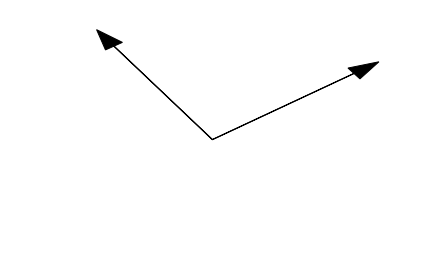

In [ ]:

# Only turn on one of these:
plot_force_components = False
plot_sparsity = False
plot_rotation = True
if plot_force_components:
    fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))
if plot_sparsity or plot_rotation:
    fig, ax = plt.subplots(1, 1)
cam = Camera(fig)


last_alpha_x1 = 0.0
last_alpha_y1 = 0.0
t = lambda _: _#tqdm
for i in t(range(0, len(messages_over_time), 1)):
    msgs = copy(messages_over_time[i])

    msgs['bd'] = msgs.r + 1e-2

    try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(msgs[msg_columns])
    except:
        msg_columns = ['e%d'%(k) for k in range(msg_dim)]
        msg_array = np.array(msgs[msg_columns])

    msg_importance = msg_array.std(axis=0)
    most_important = np.argsort(msg_importance)[-dim:]
    msgs_to_compare = msg_array[:, most_important]
    msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

    if plot_sparsity:
        ax.pcolormesh(msg_importance[np.argsort(msg_importance)[::-1][None, :15]], cmap='gray_r', edgecolors='k')
        # plt.colorbar()
        plt.axis('off')
        plt.grid(True)
        ax.set_aspect('equal')
        plt.text(15.5, 0.5, '...', fontsize=30)
        # fig.suptitle(title + test + 'mse=%.3e'%(min_result.fun/len(msgs),))
        plt.tight_layout()
    
    if plot_force_components or plot_rotation:
        pos_cols = ['dx', 'dy']
        if dim == 3:
            pos_cols.append('dz')

        # if sim != 'spring':
        #     raise NotImplementedError("The current force function is for a spring. You will need to change the force function below to that expected by your simulation.")
        # force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]
        # print(msgs)
        # print(msgs[['q1', 'q2']])
        if sim == 'spring':
            force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]
        elif sim == 'charge':
            force_fnc = lambda msg: np.array(msg[['q1']]) * np.array(msg[['q2']]) * np.array(msg[pos_cols]) / (msg.bd[:, None] ** 3)
        # elif sim == 'discontinuous':
        #     force_fnc = lambda msg: 0 if((msg.bd < 2))[:, None] else (msg.bd - 1)**2[:, None]
        else:
            raise NotImplementedError("For this simulation no force is implemented.")
        expected_forces = force_fnc(msgs)

        def percentile_sum(x):
            x = x.ravel()
            bot = x.min()
            top = np.percentile(x, 90)
            msk = (x>=bot) & (x<=top)
            frac_good = (msk).sum()/len(x)
            return x[msk].sum()/frac_good

        from scipy.optimize import minimize

        def linear_transformation_2d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2))
            )/2.0

            return score

        def out_linear_transformation_2d(alpha):
            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            return lincomb1, lincomb2

        def linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2)) +
                percentile_sum(np.square(msgs_to_compare[:, 2] - lincomb3))
            )/3.0

            return score

        def out_linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            return lincomb1, lincomb2, lincomb3

        if dim == 2:
            min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')
        if dim == 3:
            min_result = minimize(linear_transformation_3d, np.ones(dim**2 + dim), method='Powell')
        print(title, test, 'gets', min_result.fun/len(msgs))

        if plot_rotation:
            q = min_result.x
            alphax1, alphay1, offset1 = q[:3]
            alphax2, alphay2, offset2 = q[3:]
            
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            
            if (
                    (alphax2 - last_alpha_x1)**2
                    + (alphay2 - last_alpha_y1)**2  <
                   (alphax1 - last_alpha_x1)**2
                    + (alphay1 - last_alpha_y1)**2):
                
                alphax1, alphay1, offset1 = q[3:]
                alphax2, alphay2, offset2 = q[:3]
                
            last_alpha_x1 = alphax1
            last_alpha_y1 = alphay1
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            alphax1 /= s1**0.5 * 2
            alphay1 /= s1**0.5 * 2
            alphax2 /= s2**0.5 * 2
            alphay2 /= s2**0.5 * 2
            
            ax.arrow(0.5, 0.5, alphax1, alphay1, color='k', head_width=0.05, length_includes_head=True)
            ax.arrow(0.5, 0.5, alphax2, alphay2, color='k', head_width=0.05, length_includes_head=True)
            ax.axis('off')
        
        if plot_force_components:
            for i in range(dim):
                if dim == 3:
                    px = out_linear_transformation_3d(min_result.x)[i]
                else:
                    px = out_linear_transformation_2d(min_result.x)[i]

                py = msgs_to_compare[:, i]
                ax[i].scatter(px, py,
                              alpha=0.1, s=0.1, color='k')
                ax[i].set_xlabel('Linear combination of forces')
                ax[i].set_ylabel('Message Element %d'%(i+1))

                xlim = np.array([np.percentile(px, q) for q in [10, 90]])
                ylim = np.array([np.percentile(py, q) for q in [10, 90]])
                xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
                ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

                ax[i].set_xlim(xlim)
                ax[i].set_ylim(ylim)
                
        plt.tight_layout()
    
    cam.snap()

ani = cam.animate()
cam.animate().save('force_vs_msg_2.mp4')

from IPython.display import HTML
HTML(ani.to_jshtml())

### Visualizzazione delle traiettorie

Nella figura di destra:

* i cerchi colorati sono le traiettorie predette;
* i cerchi grigi sono le traiettorie simulate.

In [ ]:
from simulate import make_transparent_color
from scipy.integrate import odeint

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
camera = Camera(fig)

for current_model in [-1] + [1, 34, 67, 100, 133, 166, 199]:
    i = 4 #Use this simulation
    if current_model > len(recorded_models):
        continue

    #Truth:
    cutoff_time = 300
    times = onp.array(s.times)[:cutoff_time]
    x_times = onp.array(data[i, :cutoff_time])
    masses = x_times[:, :, -1]
    length_of_tail = 75

    #Learned:
    e = edge_index.cuda()
    ogn.cpu()
    if current_model > -1:
        ogn.load_state_dict(recorded_models[current_model])
    else:
        # Random model!
        ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
    ogn.cuda()
    
    def odefunc(y, t=None):
        y = y.reshape(5, 6).astype(np.float32)
        cur = Data(
            x=torch.from_numpy(y).cuda(),
            edge_index=e
        )
        dx = y[:, 2:4]
        dv = ogn.just_derivative(cur).cpu().detach().numpy()
        dother = np.zeros_like(dx)
        return np.concatenate((dx, dv, dother), axis=1).ravel()

    datai = odeint(odefunc, (onp.asarray(x_times[0]).ravel()), times).reshape(-1, 5, 6)
    x_times2 = onp.array(datai)

    d_idx = 10
    for t_idx in range(d_idx, cutoff_time, d_idx):
        start = max([0, t_idx-length_of_tail])
        ctimes = times[start:t_idx]
        cx_times = x_times[start:t_idx]
        cx_times2 = x_times2[start:t_idx]
        for j in range(n):
            rgba = make_transparent_color(len(ctimes), j/n)
            ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba)
            ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], color=rgba)
            black_rgba = rgba
            black_rgba[:, :3] = 0.75
            ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=black_rgba, zorder=-1)

        for k in range(2):
            ax[k].set_xlim(-1, 3)
            ax[k].set_ylim(-3, 1)
        plt.tight_layout()
        camera.snap()

camera.animate().save('multiple_animations_with_comparison.mp4')
from IPython.display import HTML
HTML(camera.animate().to_jshtml())

In [ ]:
camera.animate().save('multiple_animations_with_comparison.mp4')

# 4. Preparazione alla Regressione Simbolica

Extract the force laws with the following procedure:
- The data in `messages_over_time` correspond to inputs to, and features of, $\phi^e$, recorded during each training epoch.
- Select the last element of this list.
- Find the most significant message feature. Each message feature corresponds to 'e1', 'e2', etc. Calculate the one with the largest standard deviation.

Train [PySR](https://github.com/MilesCranmer/PySR) to fit this relationship.
Thus, we have extracted a force law from the graph network without priors on the functional form.

This is the same technique we used to extract the unknown dark matter overdensity equation from the Quijote simulations.


### Selezione del messaggio migliore

Il messaggio migliore viene convertito in file .csv

In [ ]:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(100)])

messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']]
messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']].to_csv("spring_best_messages.csv")